In [1]:
import os
import glob 
import re

from datetime import datetime
import earthpy as et
import geojson
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import pytz


In [2]:
os.chdir("../monthly")

In [3]:
file_list = glob.glob("*.geojson")

In [4]:
def extract_date_from_filename(filename):
    # Use regular expression to capture the date between 'Monthly_' and '_V3'
    match = re.search(r'Monthly_(\d{6})', filename)
    if match:
        return match.group(1)
    else:
        return None  # In case the date is not found

In [5]:
def extract_time_from_filename(filename):
    match = re.search(r'(\d{2}Z)', filename)
    if match:
        hour_int = match.group(1)[:2]
        return hour_int
    else:
        return None  # In case the time is not found

In [6]:
def convert_to_mountain_time(utc_hour):
    if utc_hour is not None:
        # Create a datetime object in UTC
        utc_time = datetime.strptime(f'{utc_hour}:00:00', '%H:%M:%S')
        utc_time = pytz.utc.localize(utc_time)  # Localize to UTC
        
        # Convert to Mountain Time (Colorado)
        mountain_time = utc_time.astimezone(pytz.timezone('America/Denver'))
        
        # Return the hour in Mountain Time
        return mountain_time.hour
    else:
        return None  # Return None if the time is invalid or missing

In [7]:
gdfs = []
for file in file_list:
    # print(file)
    gdf = gpd.read_file(file)
    # Extract the date from the filename
    date_str = extract_date_from_filename(file)
    time_int = extract_time_from_filename(file)
    gdf['date'] = pd.to_datetime(date_str, format='%m%Y')
    gdf['hour_utc'] = time_int
    gdfs.append(gdf)

gdfs_cleaned = [gdf.dropna(axis=1, how='all') for gdf in gdfs]
gdfs_cleaned[0]

,OBJECTID,FIPS,FIPS_new,field_avg,geometry,date,hour_utc
0,5,08035014300,8035,0.211645,"POLYGON ((-105.32923 39.1297, -105.32946 39.12...",2024-02-01,15
1,6,08035014107,8035,0.841271,"POLYGON ((-104.98894 39.5574, -104.98891 39.55...",2024-02-01,15
2,7,08035013904,8035,1.481537,"POLYGON ((-104.78338 39.52756, -104.78339 39.5...",2024-02-01,15
3,8,08035014503,8035,1.074619,"POLYGON ((-104.86821 39.41264, -104.86813 39.4...",2024-02-01,15
4,11,08035014108,8035,0.684989,"POLYGON ((-104.99159 39.55006, -104.99174 39.5...",2024-02-01,15
...,...,...,...,...,...,...,...
863,1435,08001008526,8001,2.576503,"POLYGON ((-104.98812 39.95758, -104.9881 39.95...",2024-02-01,15
864,1436,08001060100,8001,2.317012,"POLYGON ((-105.01685 39.95312, -105.01687 39.9...",2024-02-01,15
865,1437,08001060200,8001,2.380379,"POLYGON ((-105.03442 39.92048, -105.03442 39.9...",2024-02-01,15
866,1444,08001008538,8001,5.211911,"POLYGON ((-104.81852 39.89877, -104.81847 39.8...",2024-02-01,15


In [8]:
monthly_gdf = pd.concat(gdfs_cleaned, ignore_index=True)

In [9]:
# Add mountain time to dataframe
monthly_gdf['hour_mountain'] = monthly_gdf['hour_utc'].apply(convert_to_mountain_time)
monthly_gdf.head()

,OBJECTID,FIPS,FIPS_new,field_avg,geometry,date,hour_utc,hour_mountain
0,5,08035014300,8035,0.211645,"POLYGON ((-105.32923 39.1297, -105.32946 39.12...",2024-02-01,15,8
1,6,08035014107,8035,0.841271,"POLYGON ((-104.98894 39.5574, -104.98891 39.55...",2024-02-01,15,8
2,7,08035013904,8035,1.481537,"POLYGON ((-104.78338 39.52756, -104.78339 39.5...",2024-02-01,15,8
3,8,08035014503,8035,1.074619,"POLYGON ((-104.86821 39.41264, -104.86813 39.4...",2024-02-01,15,8
4,11,08035014108,8035,0.684989,"POLYGON ((-104.99159 39.55006, -104.99174 39.5...",2024-02-01,15,8


In [10]:
# I only want fips 8013 and and 8031
fips_to_keep = ["8013", "8031"] 
monthly_gdf["FIPS_new"] = monthly_gdf["FIPS_new"].astype(str)
filtered_gdf = monthly_gdf[monthly_gdf["FIPS_new"].isin(fips_to_keep)]

In [11]:
census_gdf = gpd.read_file('../preprocess/Colorado_Census_Tract_Boundaries.geojson')
df = pd.read_csv('../preprocess/state_and_county_fips_master.csv')


In [12]:
co_df = df[df['state']=='CO'] # Filter to only Colorado
# Create new column with County FIPS from tract fips
census_gdf['FIPS_new'] = census_gdf['FIPS'].str[:5].str.lstrip('0').astype(int)

In [13]:
filtered_gdf = filtered_gdf.to_crs(census_gdf.crs)
census_gdf['FIPS_new'] = census_gdf['FIPS_new'].astype('int64')
filtered_gdf['FIPS_new'] = filtered_gdf['FIPS_new'].astype('int64')
filtered_gdf

,OBJECTID,FIPS,FIPS_new,field_avg,geometry,date,hour_utc,hour_mountain
18,61,08013013703,8013,0.103662,"POLYGON ((-105.65185 40.02495, -105.6528 40.02...",2024-02-01,15,8
19,62,08013013705,8013,0.027603,"POLYGON ((-105.69436 39.95016, -105.69437 39.9...",2024-02-01,15,8
20,63,08013013706,8013,0.279966,"POLYGON ((-105.51202 40.02009, -105.51144 40.0...",2024-02-01,15,8
23,67,08013012206,8013,1.383907,"POLYGON ((-105.27278 40.01727, -105.27277 40.0...",2024-02-01,15,8
24,68,08013012107,8013,1.492140,"POLYGON ((-105.2727 40.03642, -105.2727 40.036...",2024-02-01,15,8
...,...,...,...,...,...,...,...,...
125834,1414,08031008305,8031,3.920340,"POLYGON ((-104.83571 39.79165, -104.83572 39.7...",2024-01-01,17,10
125835,1415,08031008306,8031,3.573776,"POLYGON ((-104.8471 39.78928, -104.8471 39.789...",2024-01-01,17,10
125851,1431,08031011902,8031,2.439372,"POLYGON ((-105.07198 39.65996, -105.07198 39.6...",2024-01-01,17,10
125852,1432,08031011903,8031,1.968481,"POLYGON ((-105.08147 39.66858, -105.08146 39.6...",2024-01-01,17,10


In [14]:
bins = [0, 1, 2, 3, 4, 5, 6, 7, float('inf')]
bin_labels = ['0-0.99', '1-1.99', '2-2.99', '3-3.99', '4-4.99', '5-5.99', '6-6.99', '7+']

filtered_gdf['field_avg_bins'] = pd.cut(filtered_gdf['field_avg'], bins=bins, labels=bin_labels, right=False)
monthly_gdf['field_avg_bins'] = pd.cut(monthly_gdf['field_avg'], bins=bins, labels=bin_labels, right=False)


In [15]:
filtered_gdf_bin_counts = filtered_gdf['field_avg_bins'].value_counts().sort_index()
monthly_gdf_bin_counts = monthly_gdf['field_avg_bins'].value_counts().sort_index()


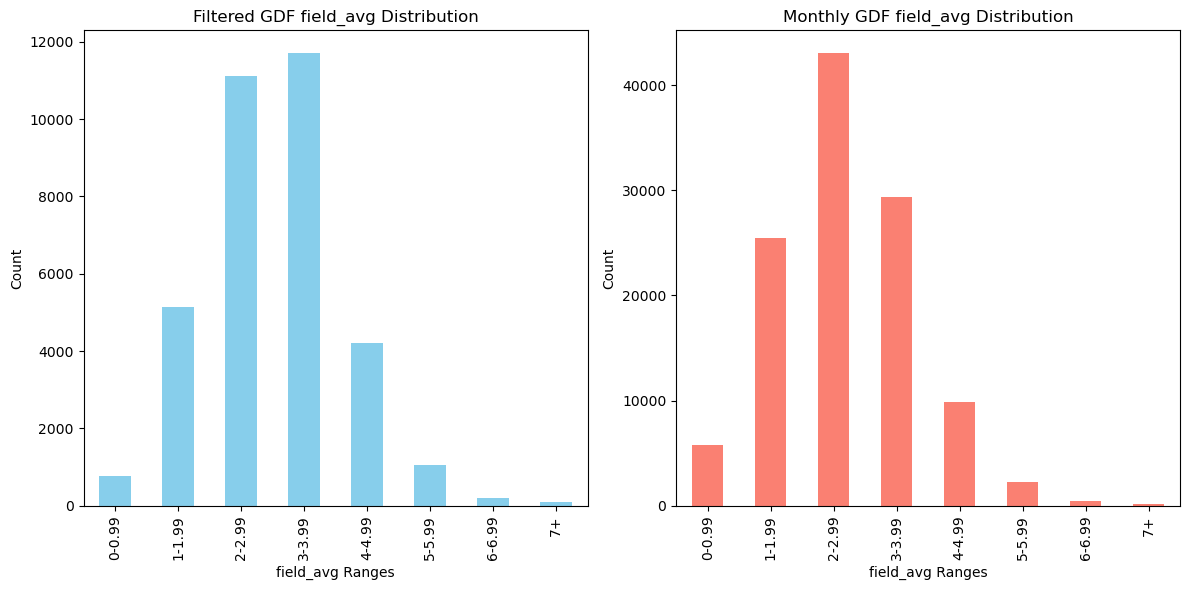

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot for filtered_gdf
filtered_gdf_bin_counts.plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Filtered GDF field_avg Distribution')
axes[0].set_xlabel('field_avg Ranges')
axes[0].set_ylabel('Count')

# Plot for monthly_gdf
monthly_gdf_bin_counts.plot(kind='bar', ax=axes[1], color='salmon')
axes[1].set_title('Monthly GDF field_avg Distribution')
axes[1].set_xlabel('field_avg Ranges')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [17]:
color_map = {
    '0-1': 'royalblue',
    '1-2': 'teal',
    '2-3': 'seafoam',  # may need to specify a hex code for 'seafoam', e.g., '#9FE2BF'
    '3-4': 'yellow',
    '4-5': 'orange',
    '5-6': 'salmon',
    '6+': 'maroon'  # Highest value
}


### hex colors for the range
Dark Blue (0-1): #00008B  
Teal (1-2): #008080  
Seafoam (2-3): #2E8B57  
Yellow (3-4): #FFFF00  
Orange (4-5): #FFA500  
Salmon (5-6): #FA8072  
Maroon (6+): #800000

In [18]:
filtered_gdf['color'] = filtered_gdf['field_avg_bins'].map(color_map)
filtered_gdf.head()

,OBJECTID,FIPS,FIPS_new,field_avg,geometry,date,hour_utc,hour_mountain,field_avg_bins,color
18,61,08013013703,8013,0.103662,"POLYGON ((-105.65185 40.02495, -105.6528 40.02...",2024-02-01,15,8,0-0.99,NaN
19,62,08013013705,8013,0.027603,"POLYGON ((-105.69436 39.95016, -105.69437 39.9...",2024-02-01,15,8,0-0.99,NaN
20,63,08013013706,8013,0.279966,"POLYGON ((-105.51202 40.02009, -105.51144 40.0...",2024-02-01,15,8,0-0.99,NaN
23,67,08013012206,8013,1.383907,"POLYGON ((-105.27278 40.01727, -105.27277 40.0...",2024-02-01,15,8,1-1.99,NaN
24,68,08013012107,8013,1.492140,"POLYGON ((-105.2727 40.03642, -105.2727 40.036...",2024-02-01,15,8,1-1.99,NaN


In [19]:
# Exclude rows where 'field_avg' is NaN
filtered_gdf = filtered_gdf.dropna(subset=['field_avg'])

In [20]:
# Now split the filtered DataFrame into FIPS_8013 and FIPS_8031
gdf_fips_8013 = filtered_gdf[filtered_gdf['FIPS_new'] == 8013]
gdf_fips_8031 = filtered_gdf[filtered_gdf['FIPS_new'] == 8031]

In [21]:
# Drop the geometry column and export to CSV
gdf_fips_8013.drop(columns='geometry').to_csv('fips_8013.csv', index=False)
gdf_fips_8031.drop(columns='geometry').to_csv('fips_8031.csv', index=False)


In [22]:
# get specifically "08013012206" - boulder
target_fips = '08013012206'

monthly_gdf[monthly_gdf['FIPS'].isin([target_fips])]
gdf_fips_8013_specific = filtered_gdf[filtered_gdf['FIPS'] == target_fips]
gdf_fips_8013_specific.drop(columns='geometry').to_csv('fips_08013012206.csv', index=False)


In [23]:
# Denver - "08031980200"
target_fips_denver = "08031980200"
monthly_gdf[monthly_gdf['FIPS'].isin([target_fips_denver])]
gdf_fips_8031_specific = filtered_gdf[filtered_gdf['FIPS'] == target_fips_denver]
gdf_fips_8031_specific.drop(columns='geometry').to_csv('fips_08031980200.csv', index=False)


In [34]:
# Get a CSV with all the data and colors for pattern work
monthly_gdf = monthly_gdf.to_crs(census_gdf.crs)
# Exclude rows where 'field_avg' is NaN
monthly_gdf = monthly_gdf.dropna(subset=['field_avg'])
final_filtered_gdf = monthly_gdf

final_filtered_gdf.drop(columns='geometry').to_csv('filtered_data_with_colors.csv', index=True)